# Numerical Solution of the Abel/Hayashi "q" investment model

## [Mateo Velásquez-Giraldo](https://github.com/Mv77)

In [1]:
# Preamble
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy import optimize

In [2]:
# Class implementation
class Qmod:
    """
    A class representing the Q investment model.
    """
    
    def __init__(self,beta = 0.98,tau = 0.05,alpha = 0.33,omega = 0.2,zeta = 0,delta = 0.1):
        """
        Inputs:
        - Beta: utility discount factor.
        - Tau: corporate tax rate.
        - Alpha: output elasticity with respect to capital.
        - Omega: adjustment cost parameter.
        - Zeta: investment tax credit.
        - Delta: capital depreciation rate.
        """
        
        # Assign parameter values
        self.beta = beta
        self.tau = tau
        self.alpha = alpha
        self.omega = omega
        self.zeta = zeta
        self.delta = delta
        
        # Create empty consumption function
        self.k1Func = None
        
        #  Compute steady state capital
        self.kss = ((1-(1-self.delta)*self.beta)/((1-self.tau)*self.alpha))**(1/(self.alpha-1))
    
    # Compute marginal productivity of capital
    def f_k(self,k):
        return(self.alpha*k**(self.alpha-1))
    
    # Compute investment adjustment cost
    def j(self,i,k):
        return(k/2*((i-self.delta*k)/k)**2*self.omega)
    
    # Derivative of adjustment cost with respect to investment
    def j_i(self,i,k):
        iota = i/k - self.delta
        return(iota*self.omega)
    
    # Derivative of adjustment cost with respect to capital.
    def j_k(self,i,k):
        iota = i/k - self.delta
        return(-(iota**2/2+iota*self.delta)*self.omega)
    
    # Error in the euler Equation implied by a k_0, k_1, k_2 triad.
    # This can be solved to obtain the adequate triads.
    def eulerError(self,k0,k1,k2):
        
        # Compute implied investments at t=0 and t=1.
        i0 = k1 - (1-self.delta)*k0
        i1 = k2 - (1-self.delta)*k1
        
        # Compute implied error in the Euler equation
        error = (1+self.j_i(i0,k0)) -\
        ((1-self.tau)*self.f_k(k1) +\
         ((1-self.delta) + (1-self.delta)*self.j_i(i1,k1) - self.j_k(i1,k1))*self.beta)
        
        return(error)
    
    # Find the k_2 implied by the euler equation for an initial k_0,
    # k_1.
    def k2(self,k0,k1):
        
        # Find the k2 that is consistent with the Euler equation
        sol = optimize.root_scalar(lambda x: self.eulerError(k0,k1,x), x0=k0, x1=self.kss)
        
        # Return exception if no compatible capital is found
        if sol.flag != "converged":
            raise Exception('Could not find capital value satisfying Euler equation')
        
        return(sol.root)
    
    # Find the capital trajectory implied by the euler equation for
    # an initial k_0, k_1.
    def shoot(self,k0,k1,t):
        
        # Initialize k
        k = np.zeros(t)
        k[0] = k0
        k[1] = k1
        
        # Simulate capital dynamics
        for i in range(2,t):
            
            try:
                k[i] = self.k2(k[i-2],k[i-1])
            except:
                # If at some point no solution can be found stop simulation.
                k[i:] = k[i]
                return(k)
                
            if k[i]<0 or (abs(k[i]-self.kss) > 2*abs(k0-self.kss)):
                # If a negative or diverging capital is obtained, stop
                # simulation
                k[i:] = k[i]
                return(k)
            
        return(k)
    
    # Shooting algorithm to find k_1 given k_0.
    def find_k1(self,k0,T=30,tol = 10**(-3),maxiter = 200):
    
        # Initialize interval over which a solution is searched.
        top = max(self.kss,k0)
        bot = min(self.kss,k0)
        
        for k in range(maxiter):
            
            # Simulate capital dynamics at the midpoint of the
            # current interval.
            init = (top+bot)/2
            path = self.shoot(k0,init,T)
            
            # Check the final value of capital
            k_f = path[-1]
            
            if np.isnan(k_f):
                bot = init
            else:
                if abs(k_f - self.kss)<tol:
                    # Stop if capital reaches and stays at
                    # the steady state
                    return(init)
                else:
                    if k_f >= self.kss:
                        # If capital ends up above steady state,
                        # we are underestimating k_1.
                        top = init
                    else:
                        # If capital ends up below steady state,
                        # we are overestimating k_1
                        bot = init
            
        return(init)
    
    # Construction of the policy rule by solving for k_1 given
    # k_0 over a grid of points and then finding an interpolating
    # function
    def solve(self,k_min=10**(-4), n_points = 50):
        
        # Create k_0 grid
        k_max = 4*self.kss
        k0 = np.linspace(k_min,k_max,n_points)
        k1 = np.zeros(len(k0))
        
        # Find k_0 at each point in the grid
        for i in range(len(k0)):
            
            k1[i] = self.find_k1(k0[i])
        
        # Interpolate over the grid to get a continuous
        # function
        self.k1Func = interpolate.interp1d(k0,k1)
    
    # Simulation of capital dynamics from a starting k_0
    def simulate(self,k0,t):
        k = np.zeros(t)
        k[0]=k0
        for i in range(1,t):
            k[i] = self.k1Func(k[i-1])
        return(k)
        
    def iota(self,lam_1):
        iota = (lam_1-1)/self.omega
        return(iota)
    
    def jkl(self,lam_1):
        iota = self.iota(lam_1)
        jk = -(iota**2/2+iota*self.delta)*self.omega
        return(jk)
        
    def dLambda(self,k,lam):
        
        bdel = self.beta*(1-self.delta)
        
        # dLambda solves the following equation:
        error = lambda x: ((1-bdel)*lam-(1-self.tau)*self.f_k(k) + self.jkl(lam+x)*self.beta)/bdel - x
        sol = optimize.root_scalar(error, bracket = [-1,1])
        
        if sol.flag != 'converged':
            return( np.float('nan') )
        else:
            return(sol.root)
    
    def dK(self,k,lam):
        iota = (lam-1)/self.omega
        return(iota*k)
    
    def plotEnvelopeCond(self,k, npoints = 10):
        
        lam_1 = np.linspace(0,2,npoints)
        prod = np.ones(npoints)*(1-self.tau)*self.f_k(k)
        iota = (lam_1-1)/self.omega
        jk = - (iota**2/2+iota*self.delta)*self.omega
        inv_gain = -jk*self.beta
        fut_val = (1-self.delta)*self.beta*lam_1
        plt.plot(lam_1,prod+inv_gain+fut_val, label = "Env. Condition value")
        plt.plot(lam_1,lam_1, linestyle = '--', color = 'k', label = "45° line")
        
        plt.legend()
        plt.title('$\\lambda (t)$ vs $\lambda (t+1)$ at $k =$ %1.2f' %(k))
        plt.xlabel('$\\lambda (t+1)$')
        plt.ylabel('$\\lambda (t)$')
        
    # Compute lambda_t using k0,k1 and the envelope condition
    def findLambda(self,k0,k1):
        
        i = k1 - (1-self.delta)*k0
        iota = i/k0 - self.delta
        lam1 = iota*self.omega + 1
        
        lam = (1-self.tau)*self.f_k(k0) - self.j_k(i,k0)*self.beta + self.beta*(1-self.delta)*lam1
        
        return(lam)
        
    
    def lambda0locus(self,k):
        
        if k > self.kss:
            x1 = 0.5
        else:
            x1 = 1.5
            
        bdel = self.beta*(1-self.delta)
        
        # Lambda solves the following equation:
        error = lambda x: (1-bdel)*x - (1-self.tau)*self.f_k(k) + self.jkl(x)*self.beta
        
        sol = optimize.root_scalar(error, x0 = 1, x1 = x1)
        if sol.flag != 'converged':
            return( np.float('nan') )
        else:
            return(sol.root)
        
    def phase_diagram(self, npoints = 200, stableArm = False):
       
        k = np.linspace(0.1*self.kss,2*self.kss,npoints)
        
        plt.figure()
        # Plot k0 locus
        plt.plot(k,1*np.ones(npoints),label = '$\\dot{k}=0$ locus')
        # Plot lambda0 locus
        plt.plot(k,[self.lambda0locus(x) for x in k],label = '$\\dot{\\lambda}=0$ locus')
        # Plot steady state
        plt.plot(self.kss,1,'*r', label = 'Steady state')
        
        if stableArm:
            
            if self.k1Func is None:
                raise Exception('Solve the model first to plot the stable arm!')
            else:
                lam = [self.findLambda(k0 = x, k1 = self.k1Func(x)) for x in k]
                plt.plot(k,lam, label = 'Stable arm')
        
        # Labels
        plt.title('Phase diagram')
        plt.xlabel('K')
        plt.ylabel('Lambda')
        plt.legend()
        plt.show()

# Examples

## 1. Model solution and policy rule.

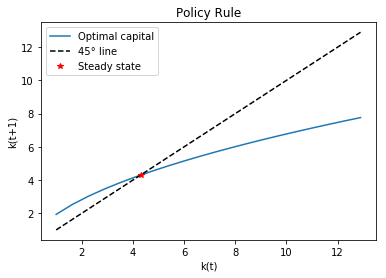

In [3]:
# Create model object
Qexample = Qmod()
# Solve to find the policy rule (k[t+1] in terms of k[t])
Qexample.solve()

# Plot policy rule
k = np.linspace(1,3*Qexample.kss,20)

plt.figure()
plt.plot(k,[Qexample.k1Func(x) for x in k], label = "Optimal capital")
plt.plot(k,k, linestyle = '--', color = 'k', label = "45° line")
plt.plot(Qexample.kss,Qexample.kss,'*r', label = "Steady state")
plt.title('Policy Rule')
plt.xlabel('k(t)')
plt.ylabel('k(t+1)')
plt.legend()
plt.show()

## 2. Simulation of capital dynamics.

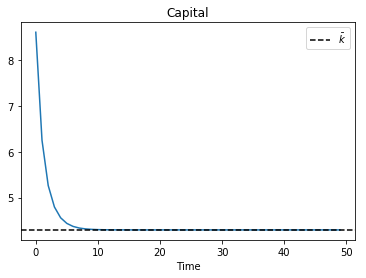

In [4]:
# Find capital dynamics from a given starting capital
k0 = 2*Qexample.kss
t = 50

# Simulate capital trajectory
k = Qexample.simulate(k0,t)

# Plot
plt.figure()
plt.plot(k)
plt.axhline(y = Qexample.kss,linestyle = '--',color = 'k', label = '$\\bar{k}$')
plt.title('Capital')
plt.xlabel('Time')
plt.legend()
plt.show()

## 3. The impact of ajdustment costs

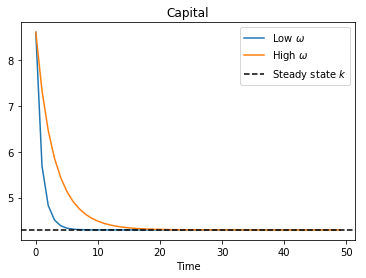

In [5]:
# Create and solve two instances, one with high and one with low adjustment costs omega
Qlow  = Qmod(omega =  0.1)
Qhigh = Qmod(omega =  0.9)

Qlow.solve()
Qhigh.solve()

# Simulate adjustment from an initial capital level
k0 = 2*Qhigh.kss
t = 50
k_low = Qlow.simulate(k0,t)
k_high = Qhigh.simulate(k0,t)

# Plot
plt.figure()
plt.plot(k_low, label = 'Low $\\omega$')
plt.plot(k_high, label = 'High $\\omega$')
plt.axhline(y = Qhigh.kss,linestyle = '--',color = 'k', label = 'Steady state ${k}$')
plt.title('Capital')
plt.xlabel('Time')
plt.legend()
plt.show()

## 4. Phase diagram.

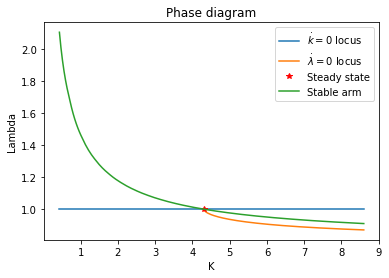

In [6]:
# Create and solve model object
Qexample = Qmod()
Qexample.solve()
# Generate its phase diagram
Qexample.phase_diagram(stableArm = True)

Why is the $\dot{\lambda}=0$ locus truncated?

With constant prices, there may be instances where $\lambda_t$ can not be equal to $\lambda_{t+1}$. Notice first that $\lambda_t$ is a function of $\lambda_{t+1}$ (current marginal value of capital is a function of its expected marginal value tomorrow).

If, for instance, $k_t$ is low, the marginal productivity of capital will be high, and this can push $\lambda_t$ above $\lambda_{t+1}$, as is the case in the following diagram, which plots $\lambda_t$ computed from the envelope condition at a fixed $k$ and varying $\lambda_{t+1}$.

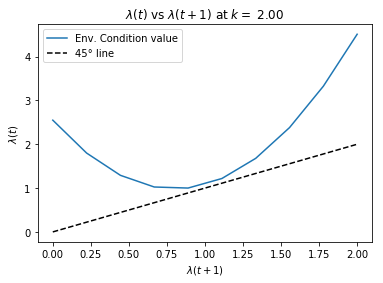

In [7]:
Qexample.plotEnvelopeCond(k=2)

Note that the envelope condition never crosses the $\lambda_t = \lambda_{t+1}$ line. Thus, there is no $\dot{\lambda}=0$ locus at $k=2$.